## Загрузка данных

In [133]:
import warnings
from typing import Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve, learning_curve

In [134]:
data = pd.read_csv("train.csv")
print("data.shape = {} rows, {} cols".format(*data.shape))
data.head(n=2)

data.shape = 60000 rows, 202 cols


,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.093,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.389,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518


In [135]:
x_train, x_valid = train_test_split(
    data.drop(["ID_code", "target"], axis=1), train_size=0.75, shuffle=True, random_state=1,
)
y_train, y_valid = train_test_split(
    data["target"], train_size=0.75, shuffle=True, random_state=1,
)
print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))

x_train.shape = 45000 rows, 200 cols
x_valid.shape = 15000 rows, 200 cols


## Решающие деревья

__Парамтеры дерева:__
* `criterion` - критерий информативности: для задачи классификации Джини / Энтроия, для задачи регрессии - дисперсия;
* `max_depth` - максимальная глубина дерева, по умолчанию, не ограничена;
* `min_samples_split` - минимальное количество объектов для проведения разбиения, по умолчанию, 2;
* `min_samples_leaf` - минимальное количество объектов для формирования листа, по умолчанию, 1;
* `max_features` - максимальное количество признаков для использования в дереве;
* `random_state` - состояние случайного счетчика, для воспроизводимости результатов;


In [41]:
model = DecisionTreeClassifier(random_state=27)
model.fit(x_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=27, splitter='best')

In [42]:
# Оценим значение метрики качества на обучении и на тесте

train_score = roc_auc_score(y_train, model.predict_proba(x_train)[:, 1])
valid_score = roc_auc_score(y_valid, model.predict_proba(x_valid)[:, 1])

print(f"Train-score: {round(train_score, 3)}, Valid-score: {round(valid_score, 3)}")

Train-score: 1.0, Valid-score: 0.557


Мы обучили максимально сложное дерево, в котором очень много разбиений. Такое дерево получилось очень хорошим на обучающей выборке, качество модели максимальное, но качество на тестовой выборке очень сильно упало. Модель на тестовой выборке не сильно отличается от прогнозов случайного генератора.

## Важность признаков, на основе решающего дерева

In [43]:
importance = pd.DataFrame({
    "features": x_train.columns,
    "importance": model.feature_importances_
})

importance = importance.sort_values(by="importance", ascending=False)
importance = importance.reset_index(drop=True)
importance.head(n=2)

,features,importance
0,var_12,0.012811
1,var_81,0.012361


## Разделяющая гиперплоскость решающего дерева

Для визуализации разделяющей гиперплоскости выберем 2 наиболее важных признака. Это нужно для удобной визуализации данных на плоскости.

In [44]:
def get_grid(data):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(
        np.arange(x_min, x_max, 0.01),
        np.arange(y_min, y_max, 0.01)
    )

In [45]:
model = DecisionTreeClassifier(random_state=27)
model.fit(
    X=x_train[["var_12", "var_81"]].sample(5000),
    y=y_train.sample(5000)
)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=27, splitter='best')

In [46]:
xx, yy = get_grid(x_train[["var_12", "var_81"]].sample(5000).values)
predicted = model.predict(np.c_[xx.ravel(), yy.ravel()])
predicted = predicted.reshape(xx.shape)

Text(0, 0.5, 'feature_2')

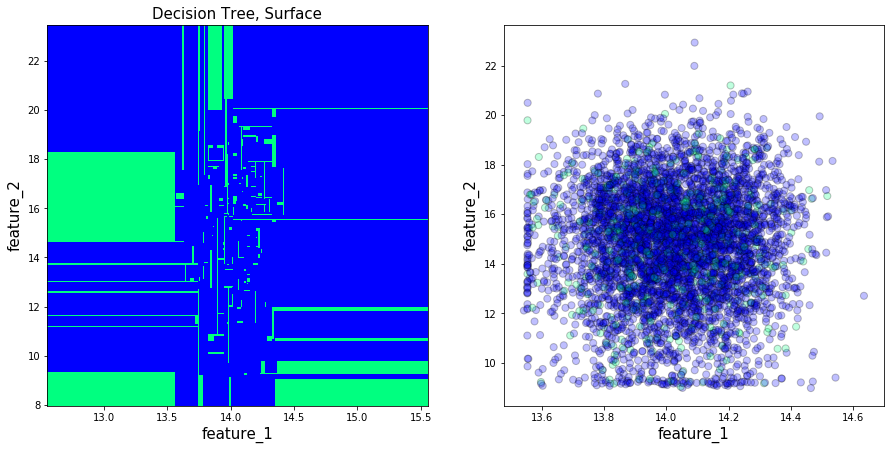

In [47]:
plt.figure(figsize=(15, 7))
plt.subplot(121)
plt.title("Decision Tree, Surface", size=15)
plt.pcolormesh(xx, yy, predicted, cmap='winter', linewidth=1.5)
plt.xlabel("feature_1", size=15)
plt.ylabel("feature_2", size=15)

plt.subplot(122)
plt.scatter(
    x_train["var_12"].sample(5000),
    x_train["var_81"].sample(5000),
    c=y_train.sample(5000),
    s=50, cmap='winter', edgecolor='k', alpha=0.25
)
plt.xlabel("feature_1", size=15)
plt.ylabel("feature_2", size=15)

## Гиперпараметры решающего дерева

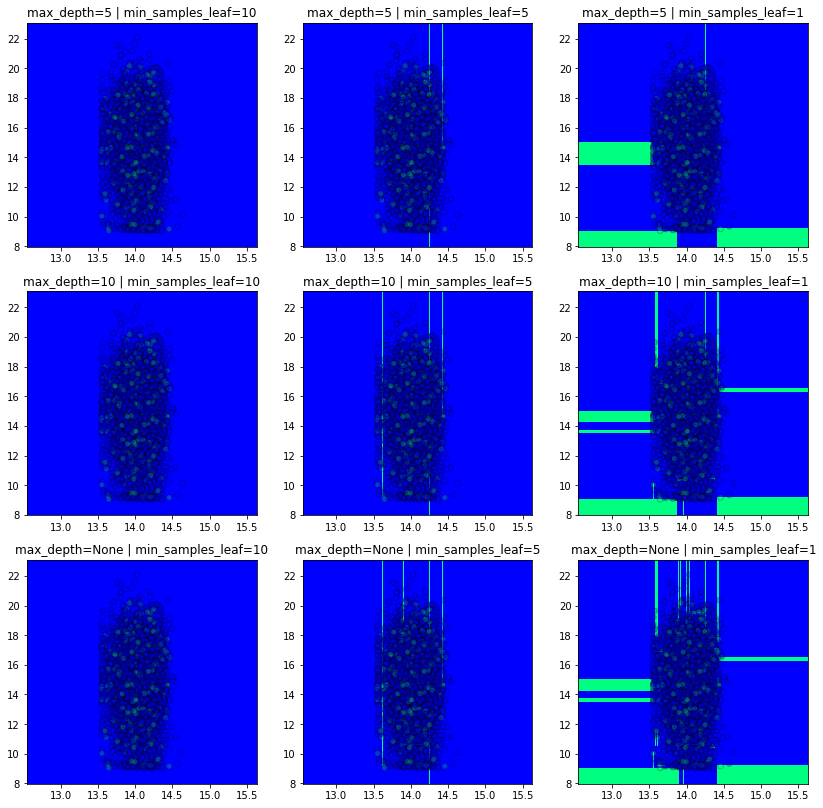

In [48]:
plt.figure(figsize=(14, 14))
data_y = y_train.sample(5000)
data_x = x_train[["var_12", "var_81"]].sample(5000)

for i, max_depth in enumerate([5, 10, None]):
    for j, min_samples_leaf in enumerate([10, 5, 1]):

        clf = DecisionTreeClassifier(
            max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=27
        )
        clf.fit(data_x, data_y)
        xx, yy = get_grid(data_x.values)
        predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
        
        plt.subplot2grid((3, 3), (i, j))
        plt.pcolormesh(xx, yy, predicted, cmap='winter')
        plt.scatter(
            data_x.values[:, 0],
            data_x.values[:, 1],
            c=data_y, s=30, 
            cmap='winter', 
            edgecolor='k',
            alpha=0.25
        )
        plt.title('max_depth=' + str(max_depth) + ' | min_samples_leaf=' + str(min_samples_leaf))

## Неустойчивость решающих деревьев

Решающие деревья — это алгоритмы, неустойчивые к изменениям обучающей выборки, т.е. при малейших её изменениях итоговый классификатор может радикально измениться. Посмотрим, как будет меняться структура дерева при обучении на разных 90%-х подвыборках.

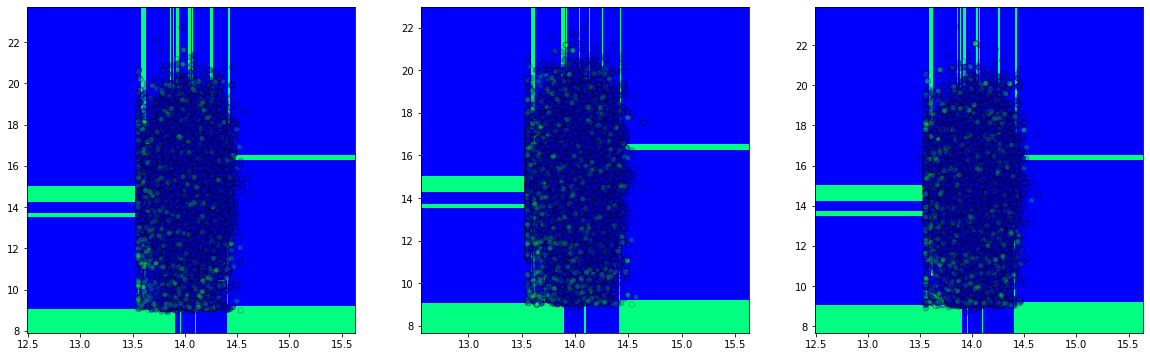

In [49]:
plt.figure(figsize=(20, 6))
data_x = x_train[["var_12", "var_81"]].values

for i in range(3):
    indecies = np.random.randint(data_x.shape[0], size=int(data_x.shape[0] * 0.7))
    current_x, current_y = data_x[indecies], y_train.values[indecies]

    model = DecisionTreeClassifier()
    model.fit(current_x, current_y)
    xx, yy = get_grid(current_x)

    predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    predicted = predicted.reshape(xx.shape)

    plt.subplot2grid((1, 3), (0, i))
    plt.pcolormesh(xx, yy, predicted, cmap='winter')
    plt.scatter(
        current_x[:, 0],
        current_x[:, 1],
        c=current_y, s=30,
        cmap='winter',
        edgecolor='k',
        alpha=0.25
    )

## Настройка гиперпараметров дерева и валидационные кривые

In [101]:
def plot_validation_curves(train_scores: np.array,
                           valid_scores: np.array,
                           figsize: Tuple[int, int] = (8, 8)
                          ):
    """
    Визуализация процесса настройки гиперпараметра
    алгоритма машинного обучения. Визуализируется значение
    метрики качества на обучащей и тестовой части данных, на
    валидационной части данных и доверительные интервалы.

    Parameters
    ----------
    train_scores: np.array
        Значения метрики качества на обучающей выборке.

    valid_scores: np.array
        Значения метрики качества на валидационной выборке.

    """
    fig = plt.figure(figsize=figsize)

    #plt.subplot(121)
    plt.title("Validation Curves", size=15)
    plt.plot(
        range(train_scores.shape[0]),
        np.mean(train_scores, axis=1),
        label="train",
        linewidth=3,
        marker="s"
    )
    plt.fill_between(
        x=range(train_scores.shape[0]),
        y1=np.mean(train_scores, axis=1)-np.std(train_scores, axis=1),
        y2=np.mean(train_scores, axis=1)+np.std(train_scores, axis=1),
        alpha=0.25
    )
    #plt.subplot(121)
    plt.plot(
        range(train_scores.shape[0]),
        np.mean(valid_scores, axis=1),
        label="valid",
        linewidth=3,
        marker="s"
    )
    plt.fill_between(
        x=range(train_scores.shape[0]),
        y1=np.mean(valid_scores, axis=1)-np.std(valid_scores, axis=1),
        y2=np.mean(valid_scores, axis=1)+np.std(valid_scores, axis=1),
        alpha=0.25
    )
    plt.legend(loc="best", fontsize=14)
    plt.ylabel("roc_auc", size=15)

## Глубина дерева - max_depth

У функции `validation_curve` есть несколько параметров:
* `x_train` - выборка для обучения;
* `y_train` - вектор целевой переменной для обучения модели;


In [54]:
train_scores, valid_scores = validation_curve(
    X=x_train,
    y=y_train,
    estimator=DecisionTreeClassifier(random_state=27),
    param_range=[-1, 2, 3, 4, 5, 6, 7, 8],
    param_name="max_depth",
    scoring="roc_auc",
    n_jobs=-1,
    cv=3,
)

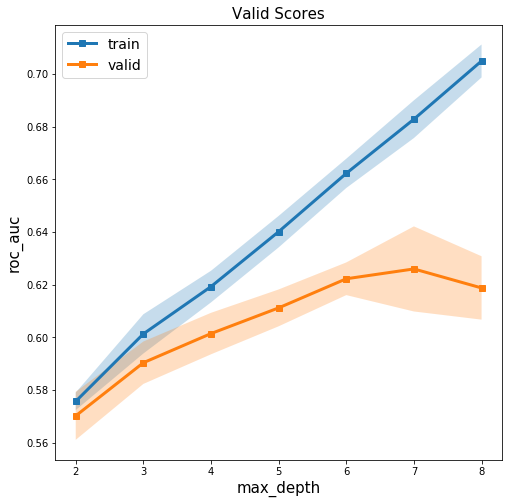

In [92]:
plot_validation_curves(
    train_scores, valid_scores
)

## Число объектов в листе - min_samples_leaf

In [93]:
train_scores, valid_scores = validation_curve(
    X=x_train,
    y=y_train,
    estimator=DecisionTreeClassifier(max_depth=7, random_state=27),
    param_range=[1, 5, 10, 25, 50, 100, 250],
    param_name="min_samples_leaf",
    scoring="roc_auc",
    n_jobs=-1,
    cv=3,
)

Text(0.5, 0, 'min_samples_leaf')

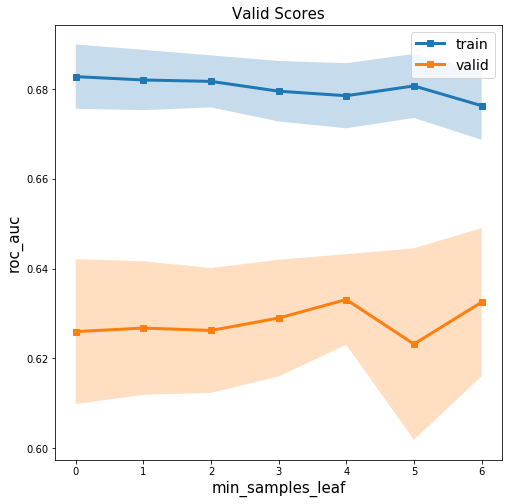

In [100]:
plot_validation_curves(
    train_scores, valid_scores
)
plt.xlabel("min_samples_leaf", size=15)

## Обучающие кривые


In [105]:
train_size, train_scores, valid_scores = learning_curve(
    X=x_train,
    y=y_train,
    estimator=DecisionTreeClassifier(max_depth=7, min_samples_leaf=50, random_state=27),
    scoring="roc_auc",
    n_jobs=-1,
    cv=3
)

Text(0, 0.5, 'roc-auc')

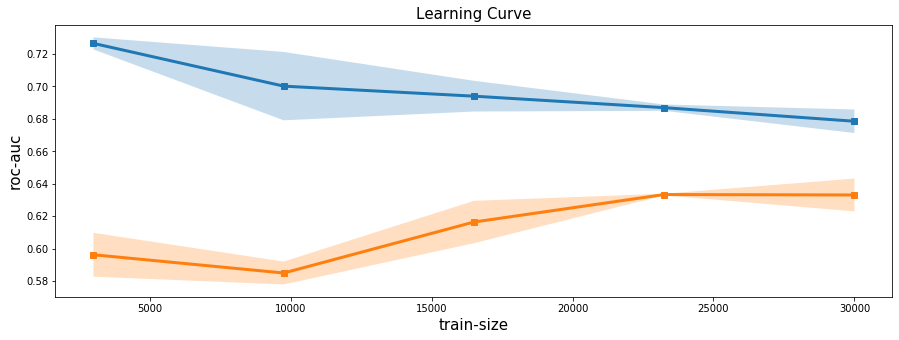

In [119]:
fig = plt.figure(figsize=(15, 5))
plt.plot(train_size, np.mean(train_scores, axis=1), marker="s", linewidth=3)
plt.fill_between(
    x=train_size,
    y1=np.mean(train_scores, axis=1)-np.std(train_scores, axis=1),
    y2=np.mean(train_scores, axis=1)+np.std(train_scores, axis=1),
    alpha=0.25
)
plt.plot(train_size, np.mean(valid_scores, axis=1), marker="s", linewidth=3)
plt.fill_between(
    x=train_size,
    y1=np.mean(valid_scores, axis=1)-np.std(valid_scores, axis=1),
    y2=np.mean(valid_scores, axis=1)+np.std(valid_scores, axis=1),
    alpha=0.25
)
plt.title("Learning Curve", size=15)
plt.xlabel("train-size", size=15)
plt.ylabel("roc-auc", size=15)